<a href="https://colab.research.google.com/github/maciejjkowara/fast_ai_for_coders/blob/main/ig_nonig_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
import io
import requests

file_url = 'https://raw.githubusercontent.com/maciejjkowara/ai_testing/main/merged.csv'

response = requests.get(file_url)
merged_df = pd.read_csv(io.StringIO(response.text))
merged_df = merged_df.loc[merged_df['broadcategorygroupname']=="Fixed Income"]

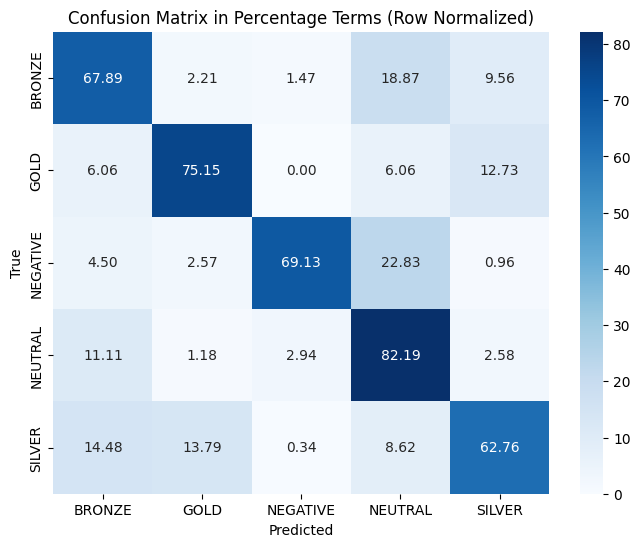

elapsed time: 30.142975091934204 seconds


In [ ]:
import time
start_time = time.time()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'merged_df' is your DataFrame

# Data Preprocessing
feature_cols = [
    'alphafor3year_percentile', 'betafor3year_percentile', 'correlationfor3year_percentile',
    'trackingerrorfor3year_percentile', 'informationratiofor3year_percentile',
    'upsidecaptureratiofor3year_percentile', 'downsidecaptureratiofor3year_percentile'
]
merged_df = merged_df.dropna(subset=feature_cols)

# Encode the categorical target variable
label_encoder = LabelEncoder()
merged_df['overall_rating_encoded'] = label_encoder.fit_transform(merged_df['overall_rating'])

# Split the data into features and target
X = merged_df[feature_cols].values
y = merged_df['overall_rating_encoded'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the target variable to categorical (one-hot encoding)
y_onehot = np.eye(len(np.unique(y)))[y]

# Convert numpy arrays to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_onehot, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoader setup
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model Setup
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.output = nn.Linear(64, y_train.shape[1])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output(x)
        return x

model = NeuralNetwork()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training
for epoch in range(50):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluation and Confusion Matrix
model.eval()
y_pred = []
y_true = []
for inputs, targets in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    _, labels = torch.max(targets, 1)
    y_pred.extend(predicted.numpy())
    y_true.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Row normalization: Sum of each row is 100%
cm_row_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_row_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix in Percentage Terms (Row Normalized)')
plt.show()
print(f"""elapsed time: {time.time() - start_time} seconds""")
